# Imports

In [1]:
from sklearn.datasets import load_digits
from typing import Any
from matplotlib import pyplot as plt
import numpy as np
from sklearn import model_selection
from matplotlib.patches import Ellipse
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

# Data

In [2]:
digits: Any = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


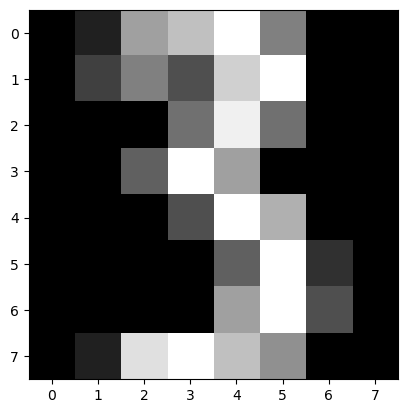

In [3]:
img = np.zeros((8, 8))
for i in range(images.shape[0]):
    if target[i] == 3:
        img = images[i]

assert 2 == len(img.shape)

plt.figure()
plt.gray()
plt.imshow(img)
plt.show()

In [4]:
# get all the threes and nines
indices = np.logical_or(target == 3, target == 9)
x = data[indices]
y = target[indices]

In [5]:
# split the data
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.4, random_state=0
)

# Features

In [6]:
# handcraft two features
def features_2d(x: np.ndarray | Any) -> np.ndarray:
    # takes: nx8x8 array
    # returns: nx2 array
    reshaped = x.reshape(-1, 8, 8)
    left_sum = reshaped[:, :4, :].sum(axis=(1, 2)).reshape(-1, 1)
    bottom_sum = reshaped[:, :, 4:].sum(axis=(1, 2)).reshape(-1, 1)
    return np.concatenate((left_sum, bottom_sum), axis=1)


features = features_2d(x)
labels = ((y == 9) * 2) - 1

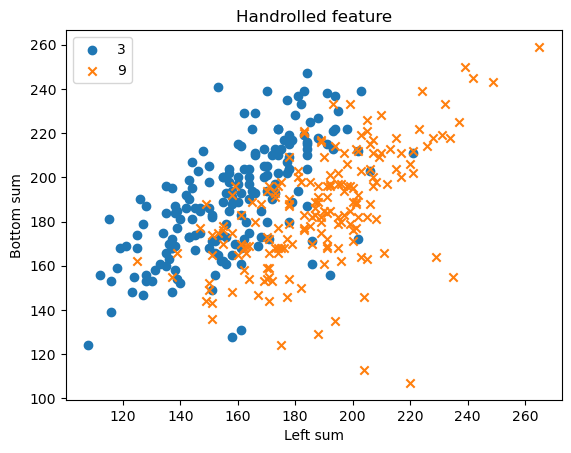

In [7]:
# plot the features
plt.figure()
plt.scatter(features[y == 3, 0], features[y == 3, 1], marker="o", label="3")
plt.scatter(features[y == 9, 0], features[y == 9, 1], marker="x", label="9")

plt.title("Handrolled feature")
plt.xlabel("Left sum")
plt.ylabel("Bottom sum")
plt.legend()

plt.show()

# Nearest mean

In [8]:
def nearest_mean(train_features, train_labels, test_features):
    # 3 -> -1
    # 9 -> 1
    neg_feat_means = train_features[train_labels == -1].mean(axis=0)
    pos_feat_means = train_features[train_labels == 1].mean(axis=0)

    if test_features is None:
        return None, neg_feat_means, pos_feat_means

    neg_dist = np.linalg.norm(test_features - neg_feat_means, axis=1)
    pos_dist = np.linalg.norm(test_features - pos_feat_means, axis=1)
    return (pos_dist < neg_dist) * 2 - 1, neg_feat_means, pos_feat_means


train_labels = ((y_train == 9) * 2) - 1
test_labels = ((y_test == 9) * 2) - 1
train_features = features_2d(x_train)
test_features = features_2d(x_test)

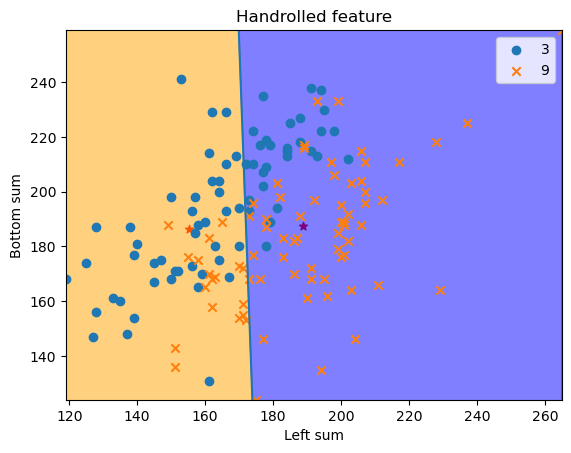

In [9]:
_, neg, pos = nearest_mean(train_features, train_labels, test_features)

x1, y1 = neg
x2, y2 = pos
mid_x = (x1 + x2) / 2
mid_y = (y1 + y2) / 2
x_min = np.min(test_features[:, 0])
x_max = np.max(test_features[:, 0])
y_max = np.max(test_features[:, 1])
y_min = np.min(test_features[:, 1])

# Perpendicular bisector
if x2 != x1:  # Prevent division by zero
    perp_slope = -(x2 - x1) / (y2 - y1)
else:
    perp_slope = float("inf")  # Vertical line

# Define x range for the plot
x_values = np.linspace(x_min, x_max, 40)
if perp_slope != float("inf"):
    y_values = perp_slope * (x_values - mid_x) + mid_y
else:
    x_values = np.full_like(x_values, mid_x)
    y_values = np.linspace(y_min, y_max, 40)

# Plot the decision region
plt.figure()
plt.plot(x_values, y_values)
plt.scatter([x1, x2], [y1, y2], color="red", marker="*")  # Points
plt.fill_between(x_values, y_values, y_values.max(), color="blue", alpha=0.5)
plt.fill_between(x_values, y_values, y_values.min(), color="orange", alpha=0.5)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Plot the points
plt.scatter(
    test_features[y_test == 3, 0], test_features[y_test == 3, 1], marker="o", label="3"
)
plt.scatter(
    test_features[y_test == 9, 0], test_features[y_test == 9, 1], marker="x", label="9"
)

plt.title("Handrolled feature")
plt.xlabel("Left sum")
plt.ylabel("Bottom sum")

plt.legend()
plt.show()

# LDA

In [10]:
# lda
def fit_lda(train_feat, train_labels):
    feat_pos = train_feat[train_labels == 1]
    feat_neg = train_feat[train_labels == -1]
    n_pos = feat_pos.shape[0]
    n_neg = feat_neg.shape[0]

    mu_pos = feat_pos.mean(axis=0)
    mu_neg = feat_neg.mean(axis=0)
    mu = np.vstack((mu_neg, mu_pos))  # checked: 2 x d

    sigma_pos = (feat_pos - mu_pos).T.dot(feat_pos - mu_pos)
    sigma_neg = (feat_neg - mu_neg).T.dot(feat_neg - mu_neg)

    sigma = 1 / train_feat.shape[0] * (sigma_pos + sigma_neg)

    prior = np.array([n_neg, n_pos]) / (n_pos + n_neg)

    return mu, sigma, prior

In [11]:
def predict_lda(mu, sigma, p, test_features):
    mu_pos = mu[1, :]
    mu_neg = mu[0, :]
    beta = np.linalg.pinv(sigma) @ (mu_pos - mu_neg).T
    b = -1 / 2 * (mu_pos + mu_neg).dot(beta) + np.log(p[1] / p[0])

    pred = np.sign(test_features @ beta + b)

    return pred

In [12]:
def plot_lda(features, labels, title):
    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    mu, covmat, p = fit_lda(features, labels)
    preds = predict_lda(mu, covmat, p, grid)
    preds = preds.reshape(xx.shape)

    eigenvalues, eigenvectors = np.linalg.eigh(covmat)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)  # 2* for semi-axes to axes

    # decision regions
    plt.contourf(xx, yy, preds, alpha=0.8)
    # data points
    plt.scatter(features[:, 0], features[:, 1], c=labels, edgecolor="k")

    # eigenvectors
    for j in (0, 1):
        for i in range(2):
            vec = eigenvectors[:, i] * np.sqrt(eigenvalues[i])
            plt.gca().quiver(
                mu[j, 0],
                mu[j, 1],
                vec[0],
                vec[1],
                scale=1,
                scale_units="xy",
                angles="xy",
                color="blue",
                width=0.005,
            )
    # gaussian ellipses
    make_ellipse = lambda x: Ellipse(
        xy=(mu[x, 0], mu[x, 1]),
        width=2 * width,
        height=2 * height,
        angle=angle,
        edgecolor="red",
        fill=False,
    )
    plt.gca().add_patch(make_ellipse(0))
    plt.gca().add_patch(make_ellipse(1))

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()

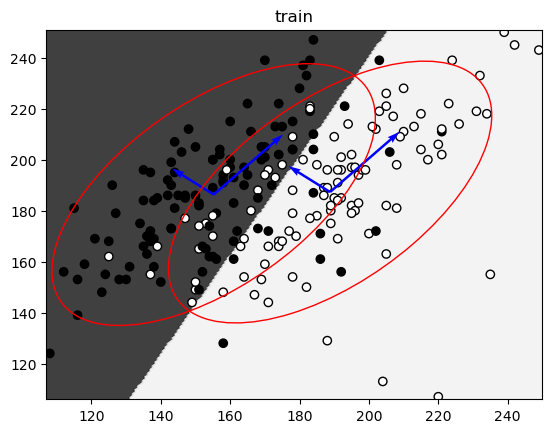

In [13]:
plot_lda(train_features, train_labels, "train")

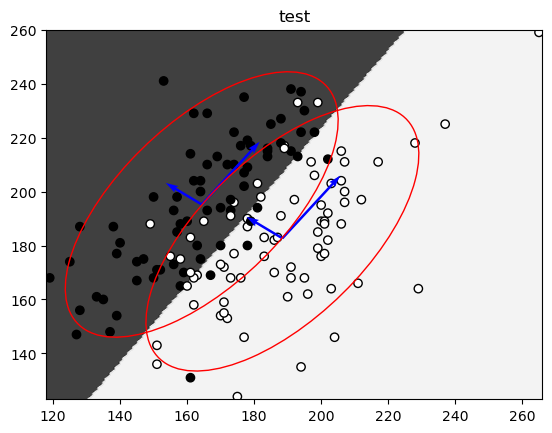

In [14]:
plot_lda(test_features, test_labels, "test")

In [15]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
accs = []
sklearn_accs = []
for i, (train_idx, test_idx) in enumerate(kf.split(features)):
    train_features = x[train_idx, :]
    train_labels = labels[train_idx]
    test_features = x[test_idx, :]
    test_labels = labels[test_idx]

    mu, covmat, p = fit_lda(train_features, train_labels)
    preds = predict_lda(mu, covmat, p, test_features)
    acc = (preds == test_labels).mean()
    accs.append(acc)

    sklearn_preds = (
        LinearDiscriminantAnalysis()
        .fit(train_features, train_labels)
        .predict(test_features)
    )
    sklearn_acc = (sklearn_preds == test_labels).mean()
    sklearn_accs.append(sklearn_acc)

print(f"ours: acc={np.mean(accs)}, sklearn: acc={np.mean(sklearn_accs)}")

ours: acc=0.9888888888888887, sklearn: acc=0.9888888888888887


# SVM

In [16]:
def relu(x):
    return x * x > 0


def svm_loss(x, y, lam, beta, b):
    return (
        1 / 2 * np.linalg.norm(beta)
        + lam * relu(1 - y * svm_pred_conf(x, beta, b)).mean()
    )


def svm_pred_conf(x, beta, b):
    return x @ beta + b


def svm_pred(x, beta, b):
    return (svm_pred_conf(x, beta, b) > 0) * 2 - 1


def svm_beta_update(x, y, lam, beta, b):
    y_pred = svm_pred_conf(x, beta, b)
    indices = y * y_pred < 1
    grad = (
        beta
        + lam * (-y.reshape(1, -1)[:, indices] @ x[indices, :]).sum(axis=0) / x.shape[0]
    )
    return -grad


def svm_b_update(x, y, lam, beta, b):
    y_pred = svm_pred_conf(x, beta, b)
    indices = y * y_pred < 1
    grad = -lam * y[indices].sum() / x.shape[0]
    return -grad

In [17]:
def fit_svm(x, y, plots=True, T=1500, lr_period=200, lr=3e-2, lam=0.01):
    b = 0
    beta = np.random.normal(loc=0.0, scale=1, size=(x.shape[1]))
    losses = []
    accs = []

    for i in range(T):
        if i % lr_period == 0 and i != 0:
            lr = lr / 3
        losses.append(svm_loss(x, y, lam, beta, b))
        acc = (svm_pred(x, beta, b) == y).mean()
        accs.append(acc)
        beta += lr * svm_beta_update(x, y, lam, beta, b)
        b += lr * svm_b_update(x, y, lam, beta, b)

    if plots:
        plt.plot(losses)
        plt.title("loss")
        plt.show()
        plt.plot(accs)
        plt.title("accuracy")
        plt.show()

    return beta, b

In [18]:
def plot_svm(features, labels, title: str, **kwargs):
    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    beta, b = fit_svm(features, labels, **kwargs)
    preds = svm_pred(grid, beta, b)
    preds = preds.reshape(xx.shape)

    # decision regions
    plt.contourf(xx, yy, preds, alpha=0.8)
    # data points
    plt.scatter(features[:, 0], features[:, 1], c=labels, edgecolor="k")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"{title}")
    plt.show()

In [19]:
train_labels = ((y_train == 9) * 2) - 1
test_labels = ((y_test == 9) * 2) - 1
train_features = features_2d(x_train)
test_features = features_2d(x_test)

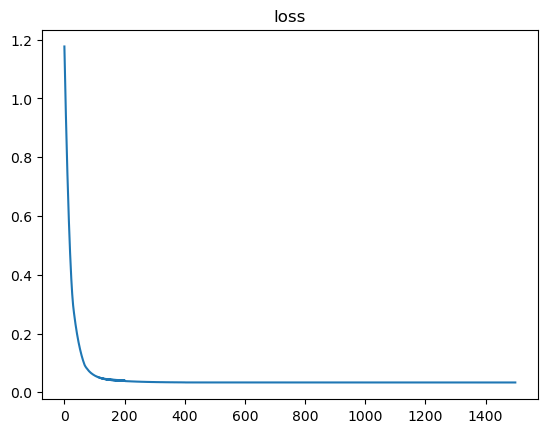

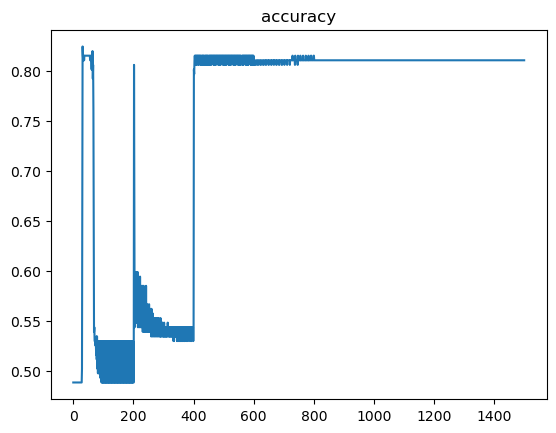

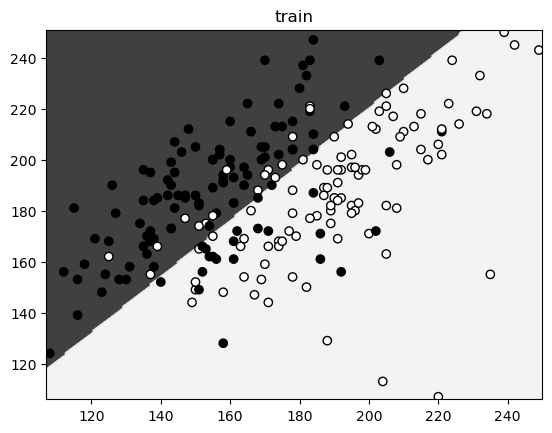

In [20]:
plot_svm(train_features, train_labels, "train")

In [21]:
lam_accs = {}
for lam_exp in range(-3, 3):
    lam = 0.01 * 10**lam_exp
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    accs = []
    for i, (train_idx, test_idx) in enumerate(kf.split(features)):
        train_features = x[train_idx, :]
        train_labels = labels[train_idx]
        test_features = x[test_idx, :]
        test_labels = labels[test_idx]

        beta, b = fit_svm(train_features, train_labels, plots=False, lam=lam)
        preds = svm_pred(test_features, beta, b)
        acc = (preds == test_labels).mean()
        accs.append(acc)
    lam_accs[lam] = np.mean(accs)

best_lam = 0
best_acc = 0
for k, v in lam_accs.items():
    print(f"lambda={k}, acc={v}")
    if v > best_acc:
        best_lam = k
        best_acc = v
print(f"best lambda: lam={best_lam}")

lambda=1e-05, acc=0.5927177177177178
lambda=0.0001, acc=0.7651651651651651
lambda=0.001, acc=0.7843843843843844
lambda=0.01, acc=0.9863363363363362
lambda=0.1, acc=0.9972222222222221
lambda=1.0, acc=0.9944444444444442
best lambda: lam=0.1


In [22]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
accs = []
sklearn_accs = []
for i, (train_idx, test_idx) in enumerate(kf.split(features)):
    train_features = x[train_idx, :]
    train_labels = labels[train_idx]
    test_features = x[test_idx, :]
    test_labels = labels[test_idx]

    beta, b = fit_svm(train_features, train_labels, plots=False, lam=best_lam)
    preds = svm_pred(test_features, beta, b)
    acc = (preds == test_labels).mean()
    accs.append(acc)

    sklearn_preds = SVC().fit(train_features, train_labels).predict(test_features)
    sklearn_acc = (sklearn_preds == test_labels).mean()
    sklearn_accs.append(sklearn_acc)

print(f"ours: acc={np.mean(accs)}, sklearn: acc={np.mean(sklearn_accs)}")

ours: acc=0.9972222222222221, sklearn: acc=0.9972222222222221


accuracy(SVM) > accuracy(LDA) > accuracy(nearest mean)